In [3]:
import pandas as pd
import torch
import numpy as np
from tqdm import tqdm

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import itertools
import copy
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [4]:
torch.set_default_device('cuda')
torch.set_default_dtype(torch.float32)

In [5]:
etf_names = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']

In [6]:
df = pd.read_pickle('combied_strats_data.pickle')

In [7]:
df.shape

(964925, 36)

In [8]:
df.sample(2)

,price_XLB,st_1_return_XLB,st_2_return_XLB,st_3_return_XLB,price_XLE,st_1_return_XLE,st_2_return_XLE,st_3_return_XLE,price_XLF,st_1_return_XLF,...,st_2_return_XLU,st_3_return_XLU,price_XLV,st_1_return_XLV,st_2_return_XLV,st_3_return_XLV,price_XLY,st_1_return_XLY,st_2_return_XLY,st_3_return_XLY
NYC,,,,,,,,,,,,,,,,,,,,,
2018-04-10 12:09:00-04:00,58.06,0.215292,0.065846,0.111725,70.04,0.226512,0.063246,0.077242,27.81,0.147094,...,0.026532,0.369553,82.07,0.260182,0.019827,0.11747,101.53,0.202221,0.269464,0.094385
2022-09-07 12:53:00-04:00,75.39,0.449001,0.205438,0.120275,77.72,0.308134,0.324562,0.164208,33.24,0.250287,...,0.541886,0.620181,126.52,0.840433,0.070946,0.23401,158.11,1.163759,1.527011,0.264704


<Axes: xlabel='NYC'>

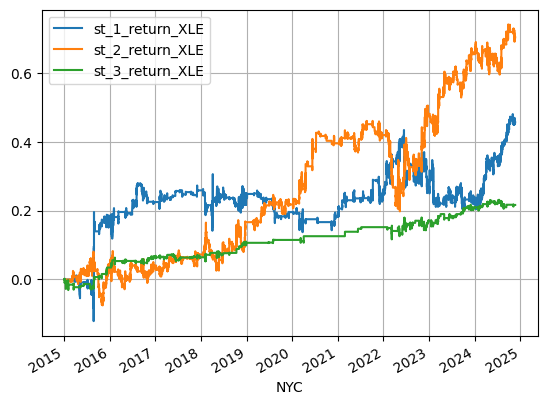

In [9]:
df[[i for i in df.columns if 'XLE' in i and 'return' in i]].plot(grid=True, legend=True)

<Axes: xlabel='NYC'>

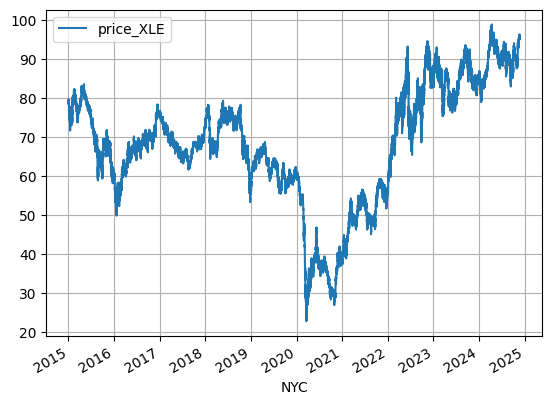

In [10]:
df['price_XLE'].plot(grid=True, legend=True)

In [11]:
df = df[[i for i in df.columns if 'return' in i]].diff()

In [12]:
df = df.resample('1H').sum()

/tmp/ipykernel_1279110/2614041725.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('1H').sum()


In [13]:


# f = plt.figure(figsize=(19, 15))
# plt.matshow(df.corr(), fignum=f.number)
# plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
# plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
# plt.title('Correlation Matrix', fontsize=16);

In [16]:
df = df.fillna(0)

In [17]:
import warnings

warnings.filterwarnings('ignore')
features = pd.DataFrame()
for col in df.columns:
    for window in tqdm([8, 24, 72, 168, 336, 772, 2016, 4032, 8064]):
        features['sum_return_' + col + '_' + str(window)] = df[col].rolling(window).sum().shift(1)
        features['std_return_' + col + '_' + str(window)] = df[col].rolling(window).std().shift(1)






100%|██████████| 9/9 [00:00<00:00, 328.65it/s]


In [18]:
features.shape

(86647, 486)

In [19]:
df.shape

(86647, 27)

In [20]:
features = features.iloc[8065:]
df = df.iloc[8065:]

In [21]:
features = features.ffill()

In [22]:
features.isna().mean().sort_values()

std_return_st_3_return_XLY_772     0.0
sum_return_st_3_return_XLY_772     0.0
std_return_st_3_return_XLY_336     0.0
sum_return_st_3_return_XLY_336     0.0
std_return_st_3_return_XLY_168     0.0
                                  ... 
sum_return_st_3_return_XLY_4032    0.0
std_return_st_3_return_XLY_4032    0.0
sum_return_st_3_return_XLY_8064    0.0
std_return_st_3_return_XLY_8064    0.0
sum_return_st_1_return_XLB_8       0.0
Length: 486, dtype: float64

In [25]:
train_data = features[features.index < '15.03.2022']
valid_data = features[(features.index > '17.03.2022') & (features.index < '15.06.2023')]
test_data = features[(features.index > '18.06.2023')]

eq_train = df[df.index < '15.03.2022']
eq_valid = df[(df.index > '17.03.2022') & (df.index < '15.06.2023')]
eq_test = df[df.index > '18.06.2023']

print(train_data.shape, eq_train.shape)
print(valid_data.shape, eq_valid.shape)
print(test_data.shape, eq_test.shape)

(55021, 486) (55021, 27)
(10919, 486) (10919, 27)
(12520, 486) (12520, 27)


In [26]:

class SharpeLoss(nn.Module):
    def __init__(self):
        super(SharpeLoss, self).__init__()

    def forward(self, model_output, eq_data):
        #sum_eq = torch.cumsum(torch.sum((eq_data * model_output),axis=1),axis=0)
        sum_eq = torch.sum((eq_data * model_output), axis=1)
        sharpe = torch.mean(sum_eq) / torch.std(sum_eq)
        # portfolio_returns = (sum_eq[1:] - sum_eq[:-1]) / sum_eq[:-1]
        #sharpe = torch.mean(portfolio_returns) / torch.std(portfolio_returns)
        return -sharpe


class SpeedLoss(nn.Module):
    def __init__(self):
        super(SpeedLoss, self).__init__()

    def forward(self, model_output, speed_lim):
        sum_of_changes = torch.sum(torch.abs(model_output[1:] - model_output[:-1]), dim=2)
        with_allowed_speed = torch.relu(sum_of_changes - speed_lim)
        expanented = torch.relu(torch.exp(with_allowed_speed) - 1)
        sum_of_exps = torch.sum(expanented, dim=0)
        total_loss = torch.mean(sum_of_exps)
        return total_loss


class SimpleNN(nn.Module):
    def __init__(self,
                 num_instr,
                 num_strat,
                 input_size,
                 hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, hidden_size6,
                 drop_size):
        super(SimpleNN, self).__init__()

        self.num_instr = num_instr
        self.num_strat = num_strat

        self.input_batch_norm = nn.BatchNorm1d(input_size)
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.dropout1 = nn.Dropout(drop_size)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size2)
        self.layer3 = nn.Linear(hidden_size2, hidden_size3)
        self.batch_norm3 = nn.BatchNorm1d(hidden_size3)
        self.layer4 = nn.Linear(hidden_size3, hidden_size4)
        self.layer5 = nn.Linear(hidden_size4, hidden_size5)
        self.layer6 = nn.Linear(hidden_size5, hidden_size6)

    def forward(self, x):
        batch_size = x.shape[0]
        #print(x.clone().detach())
        x = self.input_batch_norm(x)
        #print(x.clone().detach())
        x = F.gelu(self.layer1(x))
        #print(x.clone().detach())
        x = self.dropout1(x)
        #print(x.clone().detach())
        x = F.gelu(self.batch_norm2(self.layer2(x)))
        x = F.sigmoid(self.layer3(x))
        saved_market_regime = x.clone().detach()
        x = F.gelu(self.layer4(x))
        x = F.gelu(self.layer5(x))
        x = F.gelu(self.layer6(x))
        x = F.softmax(x.view(batch_size, self.num_instr, self.num_strat), dim=-1)

        return x, saved_market_regime

In [27]:
class LSTM_NN(nn.Module):
    def __init__(self,
                 num_instr,
                 num_strat,
                 input_size,
                 hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, hidden_size6,
                 drop_size, num_layers=5):
        super(LSTM_NN, self).__init__()

        self.num_instr = num_instr
        self.num_strat = num_strat

        self.input_batch_norm = nn.BatchNorm1d(input_size)

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size1, num_layers, batch_first=True)

        # Dropout layer
        self.dropout1 = nn.Dropout(drop_size)

        # Additional fully connected layers after LSTM
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.batch_norm3 = nn.BatchNorm1d(hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, hidden_size5)
        self.fc6 = nn.Linear(hidden_size5, hidden_size6)

    def forward(self, x):
        batch_size = x.shape[0]
        seq_len = x.shape[1]

        # Apply batch normalization to input
        x = self.input_batch_norm(x)

        lstm_out, (hn, cn) = self.lstm(x)

        x = F.gelu(self.fc2(lstm_out))
        x = self.dropout1(x)
        x = F.gelu(self.batch_norm2(x))
        x = self.fc3(x)
        x = F.sigmoid(x)

        saved_market_regime = x.clone().detach()  # Save the market regime

        x = F.gelu(self.fc4(x))
        x = F.gelu(self.fc5(x))
        x = F.gelu(self.fc6(x))

        # Reshape the output to (batch_size, num_instr, num_strat)
        x = x.view(batch_size, self.num_instr, self.num_strat)

        # Apply softmax
        x = F.softmax(x, dim=-1)

        return x, saved_market_regime

In [28]:
#all_parametrs

#общие параметры
num_instr = 9  # количество торговых инструментов
num_strat = 3  #количество торговых стратегий, у нас 3 возможные стратегии на каждый etf

#параметры сети
speed_limit = 0.05  #допустимое часовое изменеие портфеля инструмента без штрафа, speed_lim в SpeedLoss
nn_size = 22  #множетель количеств нейронов в сети, для экспериментов
dropout_size = 0.1
lstm_size = 7

#параметры обучения|
learning_rate = 0.001  #0.001
num_epochs = 6000
#early stop params
patience = 600
cur_epohs = 0
tolerance = 0.001

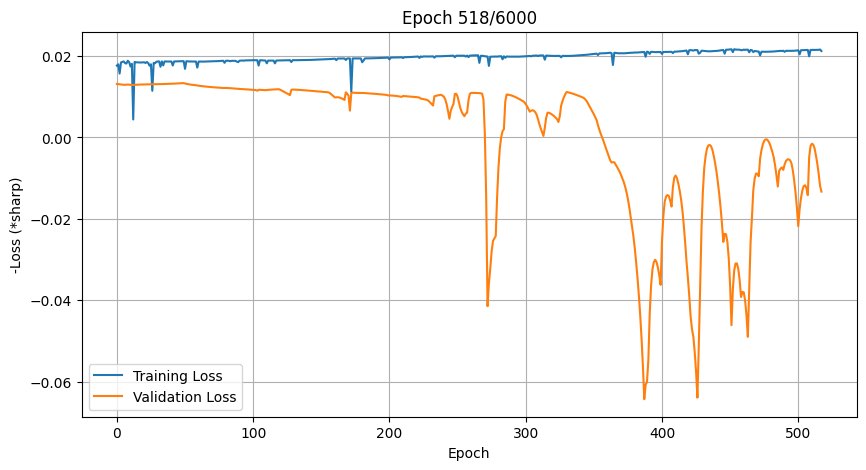

Epoch [518/6000],
    Training total Loss: -0.0212,
    Training sharpe Loss: -0.0216,
    Training speed Loss: 0.0004,
    Validation total Loss: 0.0133,
    Validation sharpe Loss: -0.0113,
    Validation speed Loss: 0.0246


KeyboardInterrupt: 

In [29]:
train_inputs = torch.tensor(train_data.to_numpy(), dtype=torch.float32)
valid_inputs = torch.tensor(valid_data.to_numpy(), dtype=torch.float32)
test_inputs = torch.tensor(test_data.to_numpy(), dtype=torch.float32)

eq_train_tensor = torch.tensor(eq_train.to_numpy(), dtype=torch.float32)
eq_valid_tensor = torch.tensor(eq_valid.to_numpy(), dtype=torch.float32)
eq_test_tensor = torch.tensor(eq_test.to_numpy(), dtype=torch.float32)

assert torch.isnan(train_inputs).any() == False
assert torch.isnan(valid_inputs).any() == False

input_size = train_data.shape[1]
# Create the model, loss function, and optimizer
model = SimpleNN(num_instr=num_instr,
                num_strat=num_strat,
                input_size=input_size,
                hidden_size1=32 * nn_size,
                hidden_size2=16 * nn_size,
                hidden_size3=2,
                hidden_size4=16 * nn_size,
                hidden_size5=32 * nn_size,
                hidden_size6=num_instr * num_strat,
                drop_size=dropout_size,
                #num_layers=lstm_size
                )

model = model.to(device=torch.get_default_device())

sharpe_loss = SharpeLoss()
speed_loss = SpeedLoss()

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
# Initialize learning rate scheduler

lr_warm_start = optim.lr_scheduler.LinearLR(optimizer, start_factor=1 / 3, end_factor=1.0, total_iters=25)
lr_linear_decay = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0,
                                              end_factor=(learning_rate / 100) / learning_rate, total_iters=num_epochs)

# Training loop parameters
train_losses = []
val_losses = []
market_regimes = []

best_score, best_state = None, None
# Training loop
for epoch in range(num_epochs):

    model.train()
    assert train_inputs.device == torch.get_default_device()
    outputs_train, _ = model(train_inputs)
    train_sharp_loss = sharpe_loss(outputs_train.view(eq_train_tensor.shape[0], eq_train_tensor.shape[1]),
                                   eq_train_tensor)
    train_speed_loss = speed_loss(outputs_train, speed_limit)

    train_total_loss = train_sharp_loss + train_speed_loss

    optimizer.zero_grad()
    train_total_loss.backward()
    optimizer.step()

    lr_warm_start.step()
    lr_linear_decay.step()

    model.eval()
    with torch.no_grad():
        outputs_valid, market_regime = model(valid_inputs)
        market_regimes.append(market_regime)

        val_sharp_loss = sharpe_loss(outputs_valid.view(eq_valid_tensor.shape[0], eq_valid_tensor.shape[1]),
                                     eq_valid_tensor)
        val_speed_loss = speed_loss(outputs_valid, speed_limit)
        val_total_loss = val_sharp_loss + val_speed_loss

    train_losses.append(train_total_loss.item() * -1)
    val_losses.append(val_total_loss.item() * -1)
    # Interactive plot
    clear_output(wait=False)
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('-Loss (*sharp)')
    plt.legend()
    plt.grid(True)
    plt.title(f'Epoch {epoch + 1}/{num_epochs}')
    plt.show()

    print(f"""Epoch [{epoch + 1}/{num_epochs}],
    Training total Loss: {train_total_loss.item():.4f},
    Training sharpe Loss: {train_sharp_loss.item():.4f},
    Training speed Loss: {train_speed_loss.item():.4f},
    Validation total Loss: {val_total_loss.item():.4f},
    Validation sharpe Loss: {val_sharp_loss.item():.4f},
    Validation speed Loss: {val_speed_loss.item():.4f}""")


    if (best_score is None) or (val_total_loss.item() < best_score - tolerance):
        best_score = val_total_loss.item()
        cur_epohs = 0
        best_state = copy.deepcopy(model).cpu().state_dict()
    else:
        cur_epohs += 1
    if cur_epohs >= patience:
        break
        print("Early stopping.")

print("Training complete.")



In [1]:
sum_eq = torch.sum((outputs_valid.view(eq_valid_tensor.shape[0], eq_valid_tensor.shape[1]) * eq_valid_tensor), axis=1)
z = pd.Series(sum_eq.detach().cpu().numpy()).cumsum()  #.plot(grid=True)
z.index = eq_valid.index
z.plot(legend=True)
(eq_valid.sum(axis=1).cumsum() *0.333).plot()

NameError: name 'torch' is not defined

<Axes: xlabel='NYC'>

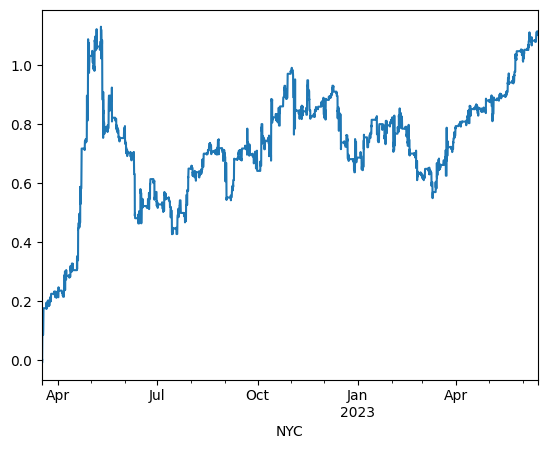

In [54]:
(eq_valid.sum(axis=1).cumsum() / 2.7).plot()

<Axes: xlabel='NYC'>

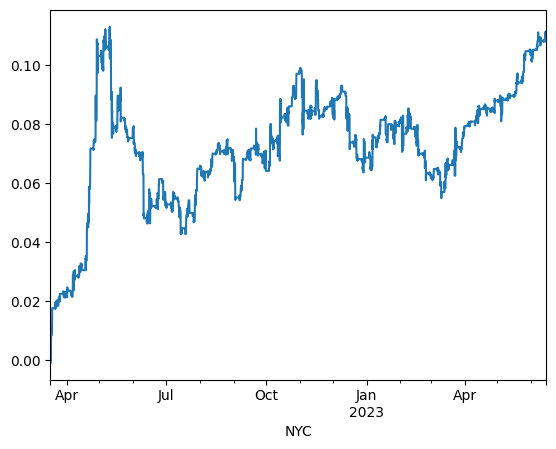

In [56]:
(eq_valid.sum(axis=1).cumsum() / 27).plot()

In [60]:
(pd.DataFrame(np.array(eq_valid_tensor.detach())).sum(axis=1).cumsum() / 27).plot()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [61]:
t = pd.DataFrame(market_regimes[-1].detach().cpu().numpy())

In [62]:
t.shape

(10919, 2)

In [63]:
t

,0,1
0,0.532562,0.470381
1,0.520679,0.483458
2,0.494990,0.505589
3,0.451594,0.537491
4,0.393767,0.579327
...,...,...
10914,0.047147,0.951313
10915,0.047115,0.951347
10916,0.047082,0.951384
10917,0.047046,0.951424


In [66]:
t['sum'] = t[0] - t[1]

<Axes: >

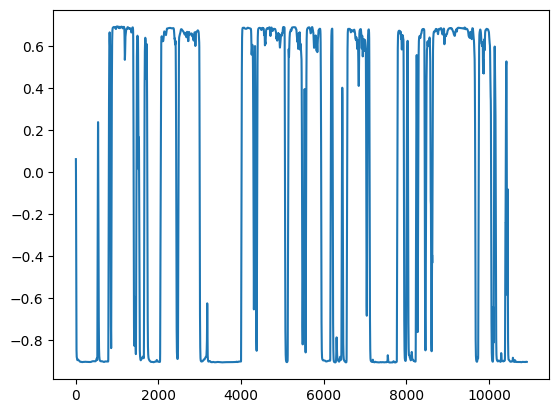

In [67]:
t['sum'].plot()

In [68]:
t['NYC'] = eq_valid.index

In [69]:
vx['ts'] = pd.to_datetime(vx['ts'])
vx = vx.set_index('ts')[['VX_mp']]


NameError: name 'vx' is not defined

<Axes: xlabel='ts'>

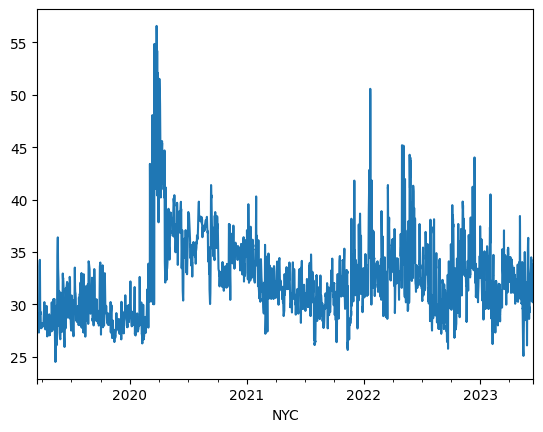

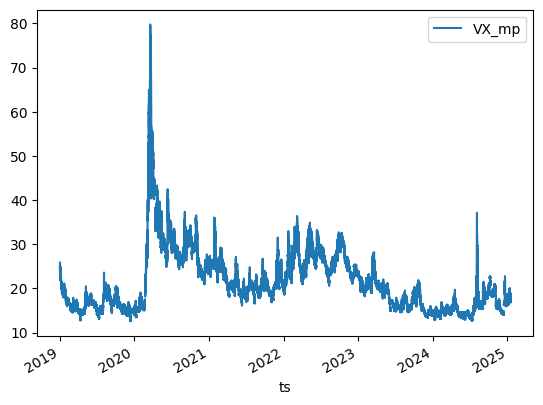

In [ ]:
(t.set_index('NYC')['sum'] * 30).plot()
vx.plot()

In [ ]:
import pandas as pd
import plotly.express as px

# Add a frame column for animation
t['frame'] = range(len(t))

# Create animated scatter plot
fig = px.scatter(t, x=0, y=1, animation_frame='frame', title="Scatter Animation",
                 labels={0: "X", 1: "Y"}, height=500, width=400)
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 5
fig.show()

<Axes: xlabel='0', ylabel='1'>

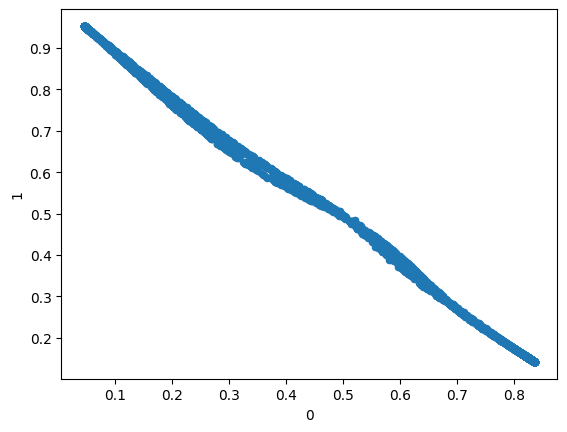

In [70]:
pd.DataFrame(t).plot.scatter(x=0, y=1)

In [71]:
model_test = copy.deepcopy(model)
model_test.load_state_dict(best_state, strict=True)

<All keys matched successfully>

In [72]:
outputs_test, market_regime_test = model(test_inputs)

In [73]:
outputs_test[10001]

tensor([[0.0583, 0.9271, 0.0147],
        [0.0541, 0.6107, 0.3352],
        [0.0762, 0.5698, 0.3540],
        [0.2892, 0.0887, 0.6221],
        [0.3897, 0.1112, 0.4991],
        [0.0132, 0.5568, 0.4300],
        [0.2156, 0.5708, 0.2136],
        [0.4148, 0.2340, 0.3513],
        [0.5235, 0.2663, 0.2101]], device='cuda:0', grad_fn=<SelectBackward0>)

In [74]:
t = pd.DataFrame(market_regime_test.cpu().detach().numpy())

<Axes: xlabel='0', ylabel='1'>

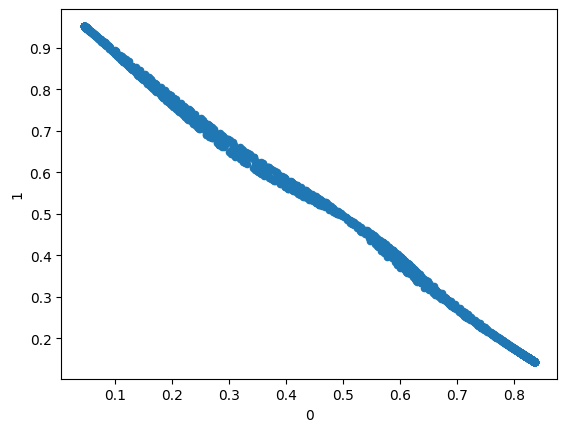

In [75]:
pd.DataFrame(t).tail(5_000).plot.scatter(x=0, y=1)

<Axes: >

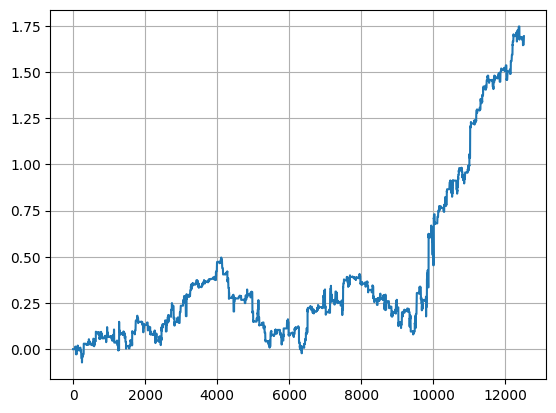

In [77]:
sum_eq = torch.sum((outputs_test.view(eq_test_tensor.shape[0], eq_test_tensor.shape[1]) * eq_test_tensor), axis=1)
pd.Series(sum_eq.cpu().detach().numpy()).cumsum().plot(grid=True)

In [78]:
z = (outputs_test.view(eq_test_tensor.shape[0], eq_test_tensor.shape[1]) * eq_test_tensor).detach().numpy()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.